In [23]:
import csv
import numpy as np
import collections

import plotly
import plotly.graph_objs as go
from plotly import tools
import plotly.io as pio
from matplotlib import pyplot as plt

def format_tool_id(tool_link):
        tool_id_split = tool_link.split( "/" )
        tool_id = tool_id_split[ -2 ] if len( tool_id_split ) > 1 else tool_link
        return tool_id

tool_usage_file = "data/tool_usage/tool-popularity.tsv"
#tool_usage_file = "data/tool_usage/tool-popu-date.tsv"
cutoff_date = '2017-12-01'
tool_usage_dict = dict()
tool_list = list()
dates = list()
with open( tool_usage_file, 'rt' ) as usage_file:
    tool_usage = csv.reader(usage_file, delimiter='\t') 
    for index, row in enumerate(tool_usage):
        if (str(row[1]) > cutoff_date) is True:
            tool_id = format_tool_id(row[0])
            tool_list.append(tool_id)
            if row[1] not in dates:
                dates.append(row[1])
            if tool_id not in tool_usage_dict:
                tool_usage_dict[tool_id] = dict()
                tool_usage_dict[tool_id][row[1]] = int(row[2])
            else:
                curr_date = row[1]
                if curr_date in tool_usage_dict[tool_id]:
                    tool_usage_dict[tool_id][curr_date] += int(row[2])
                else:
                    tool_usage_dict[tool_id][curr_date] = int(row[2])
unique_dates = list(set(dates))
for tool in tool_usage_dict:
    usage = tool_usage_dict[tool]
    #median_usage = np.median(list(usage.values()))
    dts = usage.keys()
    dates_not_present = list(set(unique_dates) ^ set(dts))
    for dt in dates_not_present:
        tool_usage_dict[tool][dt] = 0 #median_usage
    tool_usage_dict[tool] = collections.OrderedDict(sorted(usage.items()))

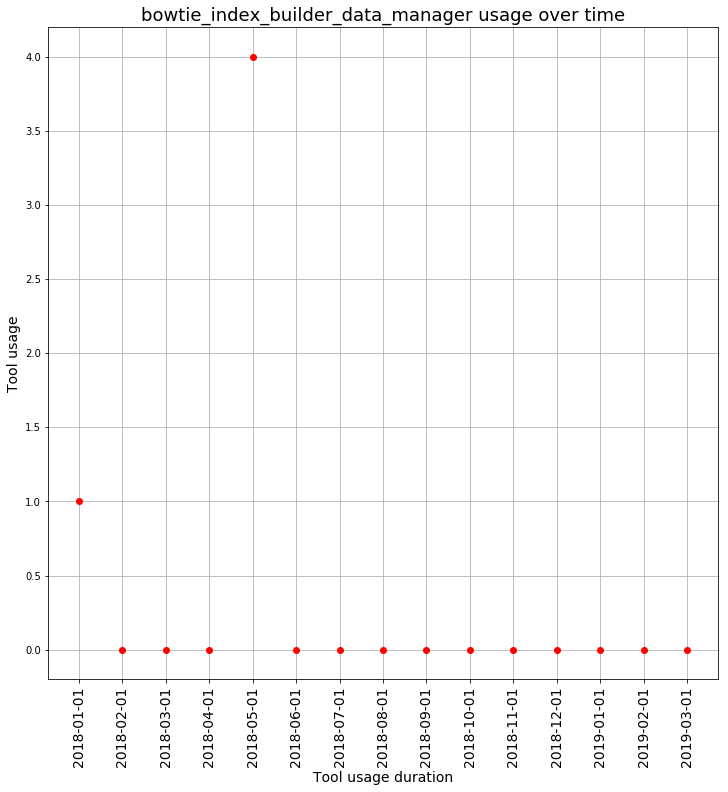

0.013333333333333308


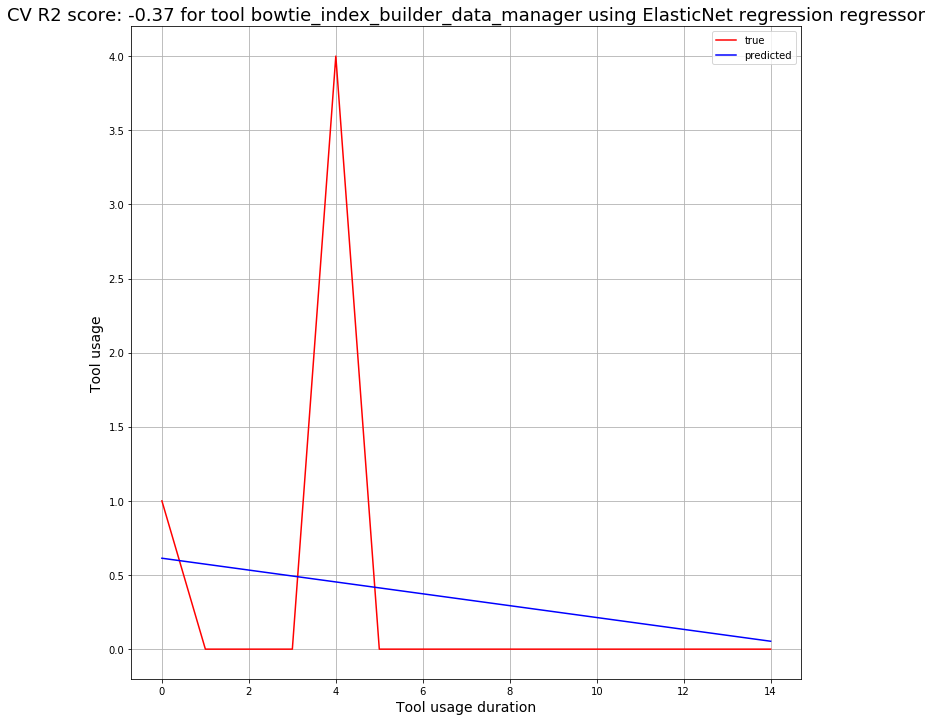

In [25]:
import warnings
from scipy import interpolate
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

size_title = 18
size_label = 14
n_pred = 2


def predict_curve(x_reshaped, y_reshaped, x_new, regressor):
    score = 0.0
    if regressor == 'lr':
        model = LinearRegression().fit(x_reshaped, y_reshaped)
    elif regressor == 'svr':
        model = SVR().fit(x_reshaped, y_reshaped)
    elif regressor == 'en':
        pipe = Pipeline(steps=[('regressor', ElasticNet())])
        param_grid = {
            'regressor__alpha': [0.1, 0.5, 0.75, 1.0],
        }
    elif regressor == 'gbr':
        model = GradientBoostingRegressor(n_estimators=20).fit(x_reshaped, y_reshaped)
    elif regressor == 'rf':
        pipe = Pipeline(steps=[('regressor', RandomForestRegressor())])
        param_grid = {
            'regressor__n_estimators': [1, 2, 3, 4, 5],
            #'regressor__criterion': ['mse', 'mae'],
            #'regressor__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5],
            #'regressor__max_features': [None, 'auto', 'log2', 'sqrt'],
            'regressor__bootstrap': [True, False]
        }
    elif regressor == 'ab':
        pipe = Pipeline(steps=[('regressor', AdaBoostRegressor())])
        param_grid = {
            'regressor__n_estimators': [1, 2, 3, 4, 5]
        }
    search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False, scoring='r2', n_jobs=2, error_score=1)
    search.fit(x_reshaped, y_reshaped)
    #print(search.best_params_)
    model = search.best_estimator_
    future_pt = [x_reshaped[-1][0] + 1]
    future_pt = np.reshape(future_pt, (1, 1))
    future_pred = model.predict(future_pt)
    print(future_pred[0])
    return model.predict(x_new), search.best_score_

def plot_predictions(true, predictions, tool_name, regressor, score):
    
    plt.figure(figsize=(12, 12))
    x_pos = np.arange(len(predictions))
    plt.plot(x_pos, true, 'r')
    plt.plot(x_pos, predictions, 'b')
    plt.xlabel('Tool usage duration', size=size_label)
    plt.ylabel('Tool usage', size=size_label)
    #plt.xticks(range(len(x_val)), x_val, size=size_label, rotation='vertical')
    plt.title(('CV R2 score: %.2f for tool %s using %s regressor' % (score, tool_name, regressor)), size=size_title)
    plt.grid(True)
    plt.legend(['true', 'predicted'])
    plt.show()
    

def plot_hist(tool_name):
    y_val = []
    x_val = []
    tool_data = tool_usage_dict[tool_name]
    for x, y in tool_data.items():
        x_val.append(x)
        y_val.append(y)

    plt.figure(figsize=(12, 12))
    x_pos = np.arange(len(x_val))
    plt.plot(x_pos, y_val, 'ro')
    plt.xlabel('Tool usage duration', size=size_label)
    plt.ylabel('Tool usage', size=size_label)
    plt.xticks(range(len(x_val)), x_val, size=size_label, rotation='vertical')
    plt.title(('%s usage over time' % tool_name), size=size_title)
    #plt.legend(['Original points', 'Adaboost regressor', 'Random forest', 'Gradient boosting regressor'])

    plt.grid(True)
    plt.show()
    
    x_pos = np.arange(len(x_val))
    x_reshaped = x_pos.reshape(len(x_pos), 1)
    y_reshaped = np.reshape(y_val, (len(x_pos), 1))

    #X_train, X_test, y_train, y_test = train_test_split(x_reshaped, y_reshaped, test_size=0.1, random_state=42)

    #predictions_lr, score = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'lr')
    predictions_en, score_en = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'en')
    #predictions_ab, score_ab = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'ab')
    #predictions_rf, score_rf = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'rf')
    #predictions_gbr = predict_curve(X_train, y_train, X_test, 'gbr')
    #predictions_xgb = predict_curve(X_train, y_train, X_test, 'xgb')
    
    #plot_predictions(y_reshaped, predictions_lr, tool_name, 'Linear regression', score)
    plot_predictions(y_reshaped, predictions_en, tool_name, 'ElasticNet regression', score_en)
    #plot_predictions(y_reshaped, predictions_ab, tool_name, 'AdaBoost', score_ab)
    #plot_predictions(y_reshaped, predictions_rf, tool_name, 'RandomForest', score_rf)
    #plot_predictions(y_test, predictions_gbr, tool_name, 'Gradient Boosting Regressor')
    #plot_predictions(y_test, predictions_gbr, tool_name, 'XGBoosting Regressor')
    

    '''poly = np.polyfit(x_pos, y_val, deg=3)
    y_ext_poly  = np.polyval(poly, new_point)
    print("Polyfit: %d" % y_ext_poly)

    func = interpolate.interp1d(x_pos, y_val, fill_value='extrapolate')
    y_ext_int = func(new_point)
    print("Inerp1d: %d" % y_ext_int)
    x_reshaped = x_pos.reshape(len(x_pos), 1)
    y_reshaped = np.reshape(y_val, (len(x_pos), 1))'''

# plot tool usage over time
#plot_hist('cummeRbund')
#plot_hist('methtools_destrand')
plot_hist('bowtie_index_builder_data_manager')
#plot_hist('IDMerger')
#plot_hist('bowtie2')
#plot_hist('bwa_mem')